## Galaxy Classification Notebook:
---

just for usability while we develop early features and model.

In [1]:
# libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from astroNN.datasets import load_galaxy10
import json

# Note, unique dependency: AstroNN

import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
## Dataset preprocessing:

images, labels = load_galaxy10()

C:\Users\dvirz\.astroNN\datasets\Galaxy10_DECals.h5 was found!


In [3]:
# Convert images to PyTorch tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2).float()  # Change data format to PyTorch (N, H, W, C) to (N, C, H, W)

# Use labels as they are (assuming labels are already a PyTorch tensor)
labels = torch.from_numpy(labels).long()
images = 1 - images

# Define a custom PyTorch Dataset
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a transformation for the dataset
"""transform = transforms.Compose([
    transforms.ToTensor(),
])"""

# Create a custom PyTorch Dataset
galaxy_dataset = GalaxyDataset(images, labels) #, transform = transforms

# Split the dataset into training and testing sets
train_size = int(0.8 * len(galaxy_dataset))
test_size = len(galaxy_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(galaxy_dataset, [train_size, test_size])

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Exploring the dataset for preprocessing:

Label: 0


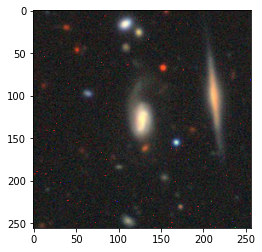

In [8]:
sample_image, sample_label = galaxy_dataset[7]

# Print the label
print(f"Label: {sample_label}")

# Convert the image tensor back to NumPy array for visualization
sample_image_np = (sample_image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

# Visualize the image as grayscale
plt.imshow(sample_image_np, cmap='gray')
plt.show()

In [ ]:
# loading hyperparameters

with open('params.json') as f:
    params = json.load(f)

# Extract hyperparameters
num_classes = params["num_classes"]
batch_size = params["batch_size"]
learning_rate = params["learning_rate"]
num_epochs = params["num_epochs"]
random_seed = params["random_seed"]

# Set random seed for reproducibility
torch.manual_seed(random_seed)


In [ ]:
# Define the CNN model
class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GalaxyCNN, self).__init__()

        # Feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classification
        self.classification = nn.Sequential(
            nn.Linear(16 * 128 * 128, 256),
            nn.Tanh(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classification(x)
        return x

In [ ]:
# Load the Galaxy10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

galaxy_dataset = Galaxy10(transform=transform)
train_size = int(0.8 * len(galaxy_dataset))
test_size = len(galaxy_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(galaxy_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Intastantiate and train the model


# Instantiate the model
model = GalaxyCNN(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')
